# FIRST build workflow 

In [21]:
# import Julia packages
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## Setup FUSE parameters

In [22]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v2);

In [23]:
ini.equilibrium.R0 = 5.0                        # meters
ini.equilibrium.B0 = 6.0                        # tesla
ini.equilibrium.ip = 9.0e6                      # amps
ini.ec_launcher[1].power_launched = 25.0e6      # watts
ini.requirements.flattop_duration = 24*3600.0   # sec

R0_scale_factor = 1.0

ini.equilibrium.R0 *= R0_scale_factor
ini.equilibrium.ip *= R0_scale_factor
ini.ec_launcher[1].power_launched *= (1/R0_scale_factor)
ini.requirements.flattop_duration *= R0_scale_factor^2;

In [24]:
# modify case parameters

#ini.equilibrium.R0 = 5.0
#ini.equilibrium.B0 = 6.0
#ini.equilibrium.ip = 8.5e6
ini.equilibrium.ϵ = missing # 1/3.5
ini.equilibrium.κ = missing # 2.1
ini.equilibrium.δ = missing # 0.6
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6
ini.equilibrium.field_null_surface = 0.8

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
#ini.core_profiles.greenwald_fraction = 1.1
ini.core_profiles.ne_ped = missing
#ini.core_profiles.greenwald_fraction_ped = 0.75
ini.core_profiles.helium_fraction = 0.04
ini.core_profiles.zeff = 1.75

#ini.ec_launcher[1].power_launched = 25.0e6 #W

if true

    mhx_order = 5
    R0 = ini.equilibrium.R0
    eps = 1/3.5
    a = R0*eps
    kapu = 2.0
    kapl = 2.2
    delu = 0.5
    dell = 0.7
    zetaou = -0.0
    zetaol = -0.2
    zetaiu = -0.0
    zetail = -0.2
    upnull = false
    lonull = false

    r, z, zref = try
        IMAS.boundary_shape(; a, eps, kapu, kapl, delu, dell, zetaou, zetaiu, zetaol, zetail, zoffset=0.0, upnull, lonull)
    catch e
        [NaN], [NaN], [NaN]
    end

    mxh = IMAS.MXH(r, z, mhx_order)
    mxh_vect = IMAS.flat_coeffs(mxh)

    ini.equilibrium.boundary_from = :MXH_params
    ini.equilibrium.MXH_params = mxh_vect 

    ini.equilibrium.xpoints = :lower 
    ini.build.symmetric = false
    ini.build.divertors = :lower


else

    ini.equilibrium.ϵ = 1/3.5
    ini.equilibrium.κ = 2.1
    ini.equilibrium.δ = 0.6

    ini.equilibrium.boundary_from = :scalars

    ini.equilibrium.xpoints = :double 
    ini.build.symmetric = false
    ini.build.divertors = :double

end

plot(r, z; aspect_ratio=:equal, lw=2, label="numerical")
display(plot!(mxh,label="MXH"))
display(mxh)

ini.build.plasma_gap = 0.125
ini.build.n_first_wall_conformal_layers = 2

ini.pf_active.n_coils_outside = 6
ini.pf_active.n_coils_inside = 0
ini.pf_active.technology = :Nb3Sn
ini.tf.shape = :princeton_D#_scaled
ini.oh.n_coils = 6;

#ini.requirements.flattop_duration = 24*3600.0;

6

In [25]:
# modify radial build

R0 = ini.equilibrium.R0
ϵ = eps
a = R0*ϵ

RiPlasma = R0 - a

layers = FUSE.OrderedCollections.OrderedDict{String,Float64}()

# HFS layers

layers["plasma"] = 2*a*(1+ini.build.plasma_gap)
layers["hfs first wall"] = 0.02
layers["hfs blanket"] = (0.55*((1/ϵ-1.8)/2.2)^0.5) * (R0/5.0) ## scale with major radius
layers["hfs high temp shield"] = RiPlasma*0.05
layers["hfs gap high temp shield vacuum vessel"] = RiPlasma * 0.02
layers["hfs vacuum vessel"] = RiPlasma * 0.05
layers["hfs gap vacuum vessel low temp shield"] = RiPlasma * 0.02
layers["hfs low temp shield"] = (0.45-0.15*((1/ϵ-1.8)/2.2)^0.5) * (R0/5.0) ## scale with major radius
layers["hfs gap low temp shield TF"] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*layers["plasma"] - layers["hfs first wall"] - layers["hfs blanket"]
    - layers["hfs high temp shield"] - layers["hfs gap high temp shield vacuum vessel"]
    - layers["hfs vacuum vessel"] - layers["hfs gap vacuum vessel low temp shield"]
    - layers["hfs low temp shield"] - layers["hfs gap low temp shield TF"]);

layers["hfs TF"] = rbCenterPost * 0.25
layers["OH"] = rbCenterPost * 0.25
layers["gap TF OH"] = RiPlasma * 0.02
layers["gap OH"] = rbCenterPost - layers["hfs TF"] - layers["gap TF OH"] - layers["OH"]

# LFS layers

layers["lfs first wall"] = 0.02
layers["lfs blanket"] = (1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5) * (R0/5.0) ## scale with major radius
layers["lfs high temp shield"] = RiPlasma * 0.05
layers["lfs gap high temp shield vacuum vessel"] = RiPlasma * 0.4
layers["lfs vacuum vessel"] = RiPlasma * 0.05
layers["lfs gap vacuum vessel low temp shield"] = RiPlasma * 0.02
layers["lfs low temp shield"] = (0.45-0.15*((1/ϵ-1.8)/2.2)^0.5) * (R0/5.0) ## scale with major radius
layers["lfs gap low temp shield TF"] = RiPlasma * 0.02
layers["lfs TF"] = layers["hfs TF"]
layers["gap cryostat"] = RiPlasma * 0.6
layers["cryostat"] = 0.2

for layer in ini.build.layers
    layer.thickness = layers[layer.name]
    if occursin("vacuum vessel", layer.name) || occursin("shield", layer.name) || occursin("blanket", layer.name)
        layer.shape = :rectangle_ellipse
    end
end


In [26]:
# modify actor parameters

act.ActorEquilibrium.model = :TEQUILA
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = [0.5]
act.ActorECsimple.width = [0.05]

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = false
act.ActorHFSsizing.verbose = false
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorLFSsizing.maintenance = :vertical
act.ActorLFSsizing.tor_modularity = 2
act.ActorLFSsizing.pol_modularity = 1
act.ActorLFSsizing.verbose = false

act.ActorPFactive.do_plot = true
act.ActorPFactive.update_equilibrium = false
act.ActorCXbuild.rebuild_wall = false

act.ActorPFdesign.do_plot = true
act.ActorPFdesign.symmetric = false

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio
act.ActorFixedProfiles.update_pedestal = true

act.ActorCoreTransport.model = :FixedProfiles

act.ActorStationaryPlasma.convergence_error = 1e-2
act.ActorStationaryPlasma.max_iter = 5
act.ActorStationaryPlasma.do_plot = false;

## Run Whole Facility

In [27]:
dd = IMAS.dd()
FUSE.init(dd, ini, act; do_plot=false);

[ Info: Equilibrium
[ Info:  TEQUILA


[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent


[ Info: CXbuild
┌ Warning: optimize_shape function could not avoid polygon crossings! Perhaps try changing shape?
└ @ FUSE ~/.julia/dev/FUSE/src/physics.jl:290


In [28]:
# modify equilibrium

if false

    XP2_R = 4.0
    XP2_Z = 4.0

    dd.pulse_schedule.position_control.x_point[1].r.reference.data .= XP2_R
    dd.pulse_schedule.position_control.x_point[1].z.reference.data .= XP2_Z

    #display(dd.pulse_schedule.position_control.x_point)
end

# modify outer strike point

if false
    OSP_R = 4.5
    OSP_Z = -3.75

    pc = dd.pulse_schedule.position_control
    time0 = 100.0

    resize!(pc.strike_point, 1; wipe=false)

    IMAS.set_time_array(pc.strike_point[1].r.reference, :data, time0, OSP_R)
    IMAS.set_time_array(pc.strike_point[1].z.reference, :data, time0, OSP_Z)

    display(dd.pulse_schedule.position_control.strike_point)
end

In [29]:
FUSE.ActorStationaryPlasma(dd, act)
FUSE.ActorHFSsizing(dd, act)
FUSE.ActorLFSsizing(dd, act)
FUSE.ActorCXbuild(dd, act)
FUSE.ActorPassiveStructures(dd, act);

[ Info: StationaryPlasma
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple


[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal


[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium


[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple


[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent


[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent


[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple


[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   TEQUILA


┌ Warning: Max number of iterations (5) has been reached with convergence error of [0.05, 0.045, 0.053, 0.018, 0.022] compared to threshold of 0.01
└ @ FUSE ~/.julia/dev/FUSE/src/actors/compound/stationary_plasma_actor.jl:156
[ Info: HFSsizing


[ Info:  FluxSwing
[ Info:  Stresses
[ Info: LFSsizing
[ Info: CXbuild
┌ Warning: optimize_shape function could not avoid polygon crossings! Perhaps try changing shape?
└ @ FUSE ~/.julia/dev/FUSE/src/physics.jl:290


[ Info: PassiveStructures


In [30]:
# set PF coil locations

import FUSE: init_pf_active!
import IMAS: BuildLayerType, _plasma_, _gap_, _oh_, _tf_, _shield_, _blanket_, _wall_, _vessel_, _cryostat_, _divertor_, _port_
import IMAS: BuildLayerSide, _lfs_, _lhfs_, _hfs_, _in_, _out_

init_pf_active!(dd.pf_active, dd.build, dd.equilibrium.time_slice[], [6,6])
coil_w = dd.pf_active.coil[7].element[1].geometry.rectangle.width

vessel = IMAS.get_build_layer(dd.build.layer; fs=_hfs_, type=_vessel_)
port = dd.build.structure[3]
lt_shield = IMAS.get_build_layer(dd.build.layer; name="lfs low temp shield")

toprail_R = [vessel.end_radius+coil_w/2, minimum(port.outline.r)-coil_w/2]
toprail_Z = maximum(lt_shield.outline.z)+coil_w/2*1.25

outrail_R = maximum(port.outline.r[port.outline.z .> 0])+coil_w/2*1.25
outrail_Z = [maximum(vessel.outline.z), minimum(port.outline.z)-coil_w/2*1.25]

botrail_R = [vessel.end_radius+coil_w, maximum(vessel.outline.r)-coil_w*2]
botrail_Z = minimum(lt_shield.outline.z)-coil_w/2*1.25

dd.pf_active.coil[7].element[1].geometry.rectangle.r = sum(toprail_R)/2
dd.pf_active.coil[7].element[1].geometry.rectangle.z = toprail_Z

dd.pf_active.coil[8].element[1].geometry.rectangle.r = outrail_R
dd.pf_active.coil[8].element[1].geometry.rectangle.z = maximum(outrail_Z)

dd.pf_active.coil[9].element[1].geometry.rectangle.r = outrail_R
dd.pf_active.coil[9].element[1].geometry.rectangle.z = sum(outrail_Z)/2

dd.pf_active.coil[10].element[1].geometry.rectangle.r = outrail_R-2*coil_w
dd.pf_active.coil[10].element[1].geometry.rectangle.z = minimum(outrail_Z)

dd.pf_active.coil[11].element[1].geometry.rectangle.r = sum(botrail_R)/2
dd.pf_active.coil[11].element[1].geometry.rectangle.z = botrail_Z

dd.pf_active.coil[12].element[1].geometry.rectangle.r = minimum(botrail_R)
dd.pf_active.coil[12].element[1].geometry.rectangle.z = botrail_Z;

In [31]:
FUSE.ActorStationaryPlasma(dd, act)
FUSE.ActorStresses(dd, act)
FUSE.ActorFluxSwing(dd, act)
FUSE.ActorNeutronics(dd, act)
FUSE.ActorBlanket(dd, act)
FUSE.ActorDivertors(dd, act)
FUSE.ActorBalanceOfPlant(dd, act)
FUSE.ActorCosting(dd, act);

[ Info: StationaryPlasma
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current
[ Info:   SteadyStateCurrent


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple


[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple
[ Info:  Current


[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info:  CoreTransport
[ Info:   FixedProfiles
[ Info:    Pedestal
[ Info:  HCD
[ Info:   ECsimple
[ Info:   ICsimple
[ Info:   LHsimple
[ Info:   NBsimple


[ Info:  Current
[ Info:   SteadyStateCurrent
[ Info:  Equilibrium
[ Info:   TEQUILA


[ Info: Stresses
[ Info: FluxSwing


[ Info: Neutronics


[ Info: Blanket


[ Info:  CXbuild
┌ Warning: optimize_shape function could not avoid polygon crossings! Perhaps try changing shape?
└ @ FUSE ~/.julia/dev/FUSE/src/physics.jl:290


[ Info: Divertors


[ Info: BalanceOfPlant


[ Info:  HeatTransfer


[ Info:  ThermalCycle


[ Info:  PowerNeeds


[ Info: Costing
[ Info:  GASCCosting
[ Info:   SheffieldCosting


## Summary

In [32]:
# print important results
FUSE.extract(dd)

GEOMETRY                        EQUILIBRIUM                     TEMPERATURES                    DENSITIES                       
────────────────────────────    ────────────────────────────    ────────────────────────────    ────────────────────────────    
R0 → 5 [m]                      B0 → 6 [T]                      Te0 → 29.8 [keV]                ne0 → 1.62e+20 [m⁻³]            
a → 1.43 [m]                    ip → 8.71 [MA]                  Ti0 → 24.6 [keV]                ne_ped → 9.5e+19 [m⁻³]          
1/ϵ → 3.5                       q95 → 4.95                      <Te> → 12 [keV]                 <ne> → 1.21e+20 [m⁻³]           
κ → 2.1                         <Bpol> → 0.741 [T]              <Ti> → 10.1 [keV]               ne0/<ne> → 1.34                 
δ → 0.481                       βpol_MHD → 2.32                 Te0/<Te> → 2.49                 fGW → 0.998                     
ζ → -0.0507                     βtor_MHD → 0.0383               Ti0/<Ti> → 2.43                 z

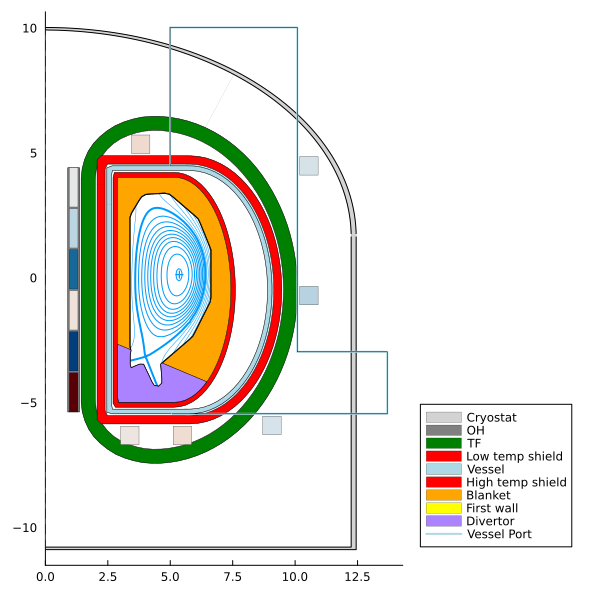

In [33]:
# plot tokamak build

p = plot(dd.equilibrium, cx=true)
plot!(p,dd.build)
plot!(p,dd.pf_active, colorbar=false)
plot!(p,size=(600,600))
display(p)
savename = "R0_$(R0)_build_plot"
savefig(savename*".pdf")
savefig(savename*".png");

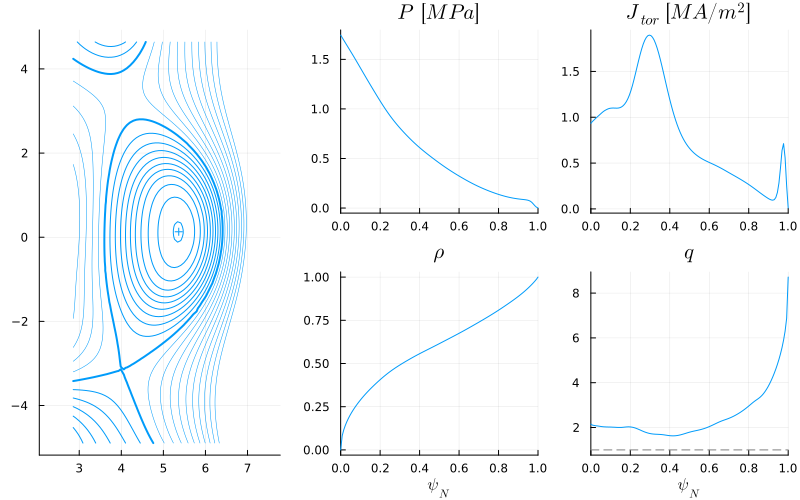

In [34]:
# plot plasma equilibrium
p = plot(dd.equilibrium)
display(p)

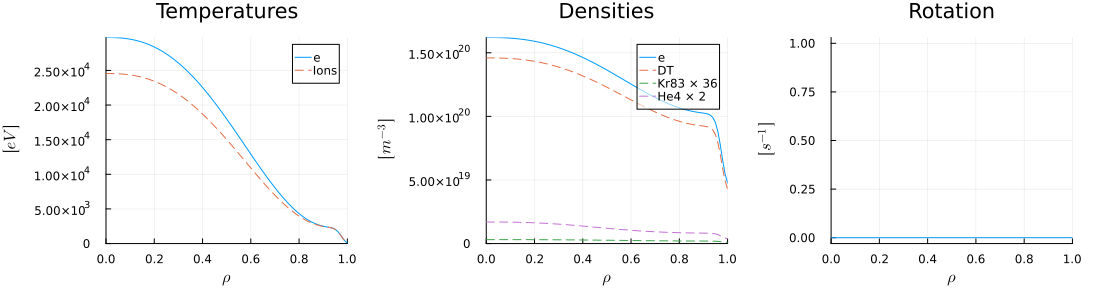

In [35]:
# plot plasma profiles
p = plot(dd.core_profiles)
display(p)
savename = "R0_$(R0)_coreprofile_plot"
savefig(savename*".pdf");

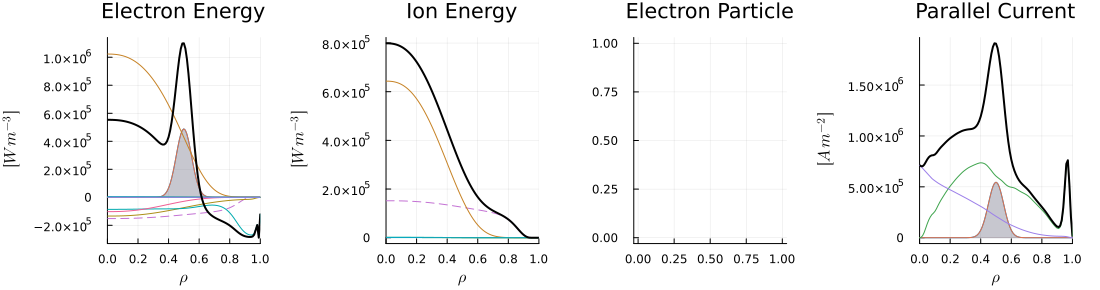

In [36]:
# plot plasma H & CD sources and sinks
p = plot(dd.core_sources, legend=false)
display(p)
savename = "R0_$(R0)_coresource_plot"
savefig(savename*".pdf");

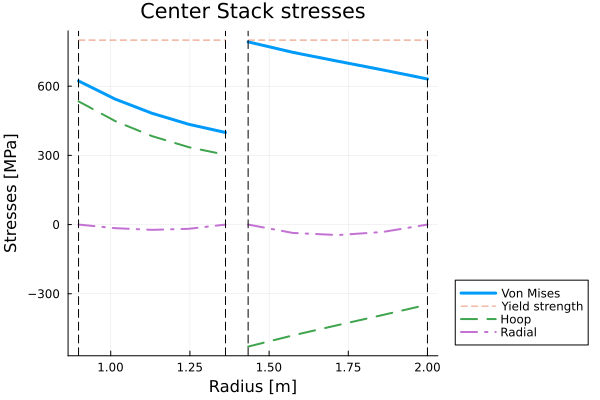

In [37]:
# plot center stack coil stresses
p = plot(dd.solid_mechanics.center_stack.stress)
display(p)
savename = "R0_$(R0)_coilstress_plot"
savefig(savename*".pdf");

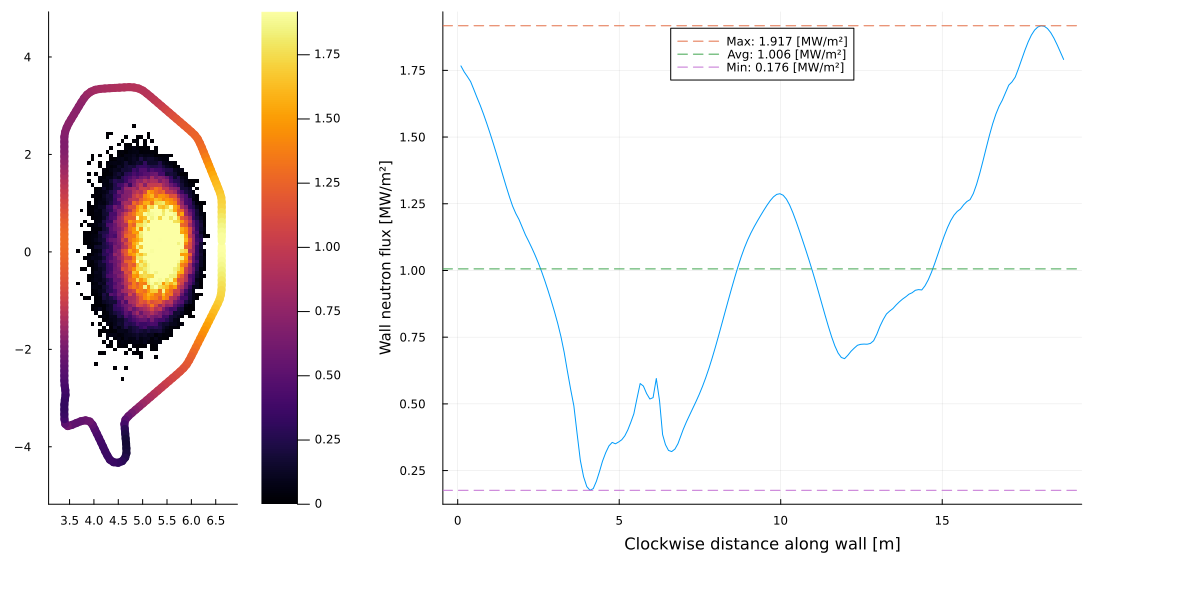

In [38]:
# plot first wall neutron loading
if false
    xlim = extrema(dd.neutronics.first_wall.r)
    xlim = (xlim[1] - ((xlim[2] - xlim[1]) / 10.0), xlim[2] + ((xlim[2] - xlim[1]) / 10.0))
    p = plot(size=(500,700))
    plot!(p,dd.neutronics.time_slice[].wall_loading; xlim)
    neutrons = FUSE.define_neutrons(dd, 100000)[1]
    plot!(p,neutrons, dd.equilibrium.time_slice[]; xlim)
    display(p)
    savename = "R0_$(R0)_neutron_plot"
    savefig(savename*".png");
end
if true
    xlim = extrema(dd.neutronics.first_wall.r)
    xlim = (xlim[1] - ((xlim[2] - xlim[1]) / 10.0), xlim[2] + ((xlim[2] - xlim[1]) / 10.0))
    l = @layout [a{0.3w} b{0.6w,0.9h}]
    p = plot(; layout=l, size=(1200, 600))
    plot!(p, dd.neutronics.time_slice[].wall_loading; xlim, subplot=1)
    neutrons = FUSE.define_neutrons(dd, 100000)[1]
    plot!(p, neutrons, dd.equilibrium.time_slice[]; xlim, subplot=1)
    plot!(p, dd.neutronics.time_slice[].wall_loading; cx=false, subplot=2, ylabel="")
    display(p)
end

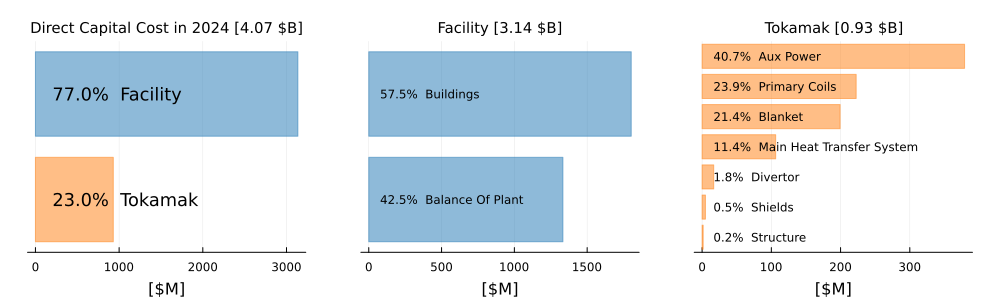

In [39]:
# plot capital cost breakdown
p=plot(dd.costing.cost_direct_capital)
display(p)
savename = "R0_$(R0)_cost_plot"
savefig(savename*".pdf");